In [2]:
%pip install googlemaps mapbox geopy osmnx networkx scikit-learn Nominatim folium

Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.

  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Installing backend dependencies: started
  Installing backend dependencies: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Using cached mapbox-0.18.1-py2.py3-none-any.whl.metadata (4.8 kB)
  Using cached nominatim-0.1.tar.gz (1.7 kB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finis

In [2]:
#!python -m pip install --upgrade pip

In [3]:
#%pip install --user python-dotenv

In [4]:
from dotenv import load_dotenv
import os

In [5]:
# Tu clave de API
# Cargar las variables de entorno desde el archivo .env
load_dotenv()

# Función para obtener una variable de entorno
def get_env_variable(var_name):
    value = os.getenv(var_name)
    if value is None:
        raise EnvironmentError(f"La variable de entorno {var_name} no está definida")
    return value

In [6]:
import heapq
import csv
import math
import time
import random
import requests
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt
from shapely.geometry import Point
import matplotlib.colors as mcolors
from geopy.geocoders import Nominatim
from datetime import datetime, timedelta
from matplotlib.lines import Line2D
from collections import Counter

In [7]:
# # Descargar los límites (Lima Moderna)
# lima_moderna_places = ['San Miguel, Lima, Peru',
#                         'Magdalena del Mar, Lima, Peru', 
#                         'Pueblo Libre, Lima, Peru',
#                         'Miraflores, Lima, Peru', 
#                         'San Isidro, Lima, Peru', 
#                         'Jesus Maria, Lima, Peru', 
#                         'Breña, Lima, Peru',
#                         'Lince, Lima, Peru', 
#                         'Barranco, Lima, Peru',
#                         'San Borja, Lima, Peru', 
#                         'Santiago de Surco, Lima, Peru',
#                         'La Victoria, Lima, Peru',
#                         'Chorrillos, Lima, Peru',
#                         'Surquillo, Lima, Peru',
#                         ]

# lima_moderna_boundaries = ox.geocode_to_gdf(lima_moderna_places)

# G_lima = ox.graph_from_place('Lima Metropolitana, Peru', network_type='drive')

# def remove_nodes_outside_boundaries(G, boundaries_gdf):
#     nodes_to_remove = []
#     for node, data in G.nodes(data=True):
#         point = Point(data['x'], data['y'])  
#         if not boundaries_gdf.geometry.contains(point).any():  
#             nodes_to_remove.append(node)

#     G.remove_nodes_from(nodes_to_remove)  

# remove_nodes_outside_boundaries(G_lima, lima_moderna_boundaries)

# ox.plot_graph(G_lima)

In [8]:
# ox.save_graphml(G_lima, filepath='lima_moderna1.graphml')

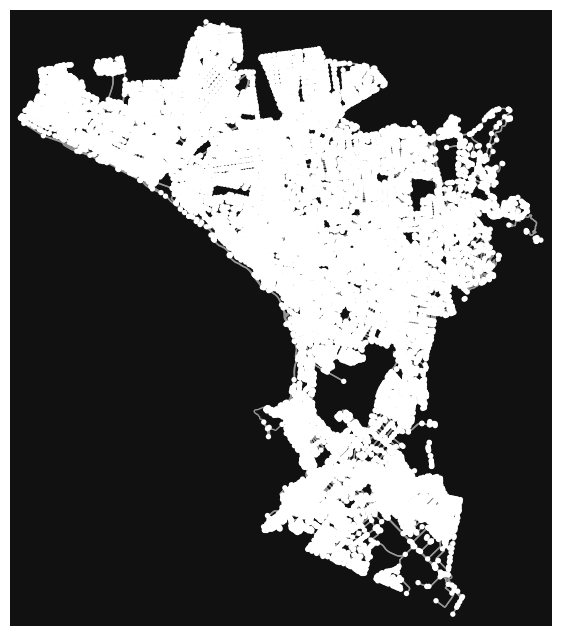

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [9]:
G_lima = ox.load_graphml('lima_moderna1.graphml')

ox.plot_graph(G_lima)

In [10]:
print(len(G_lima.nodes))

18521


motorway_link
carretera panamericana sur
carretera panamericana sur
avenida caminos del inca
avenida caminos del inca
motorway_link
carretera panamericana sur
primary_link
avenida caminos del inca
avenida caminos del inca
avenida caminos del inca
avenida alameda san marcos
avenida alameda san marcos
avenida alameda premio real
avenida alameda san marcos
avenida alameda san marcos
avenida alameda san marcos
avenida alameda san marcos
tertiary_link
avenida alameda san marcos
avenida hernando de lavalle
avenida hernando de lavalle
avenida hernando de lavalle
avenida hernando de lavalle
avenida alameda las garzas reales
avenida hernando de lavalle
avenida hernando de lavalle
avenida alameda los horizontes
avenida alameda sur
avenida costanera
avenida costanera
avenida costanera
avenida costanera
avenida alameda los horizontes
avenida alameda los horizontes
secondary
avenida alameda los horizontes
avenida alameda premio real
avenida alameda premio real
avenida alameda premio real
avenida al

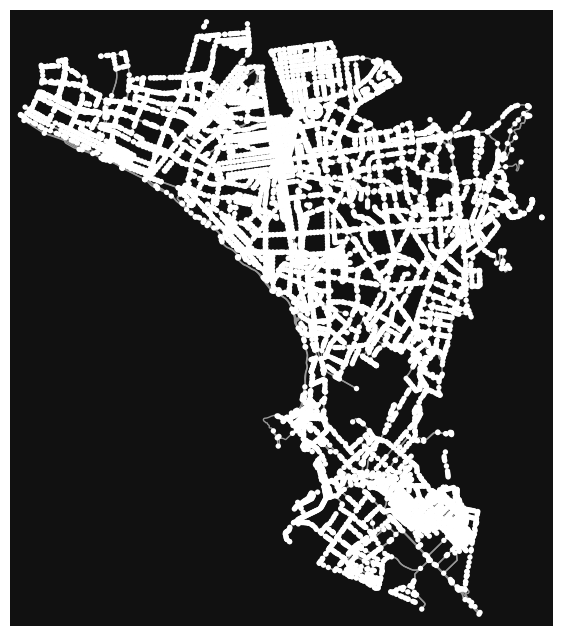

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [11]:
custom_road_types = [
    'avenue','avenida', 'carretera', 'boulevard', 'motorway', 'trunk', 'primary',
    'prolongación','vía','ovalo','circuito','bajada' ,'subida','quebrada', 'primary_link', 'secondary', 'secondary_link'
    'plaza','malecón', 'tertiary','tertiary_link','vial','intercambio' ,'motorway_link','Jirón','Calle'
]

def filter_custom_roads(G, road_types):
    """
    Filters the graph to keep only specified road types.
    """
    edges_to_keep = []
    roadNameof = {}
    
    for u, v, k, d in G.edges(keys=True, data=True):
        # Check if 'highway' exists and matches road types
        highway_match = 'highway' in d and any(road_type in d['highway'] for road_type in road_types)
        
        # Check if 'name' exists, is a string, and matches road types
        name_match = 'name' in d and isinstance(d['name'], str) and any(road_type in d['name'].lower() for road_type in road_types)
        
        # Keep edges that match either condition
        if highway_match or name_match:
            edges_to_keep.append((u, v, k))
            if name_match:
                name = d['name'].lower()
            else: name = d['highway']
            roadNameof[u] = name
            roadNameof[v] = name
            print(name)
    
    return G.edge_subgraph(edges_to_keep).copy(), roadNameof


G_lima, roadNameof = filter_custom_roads(G_lima, custom_road_types)

ox.plot_graph(G_lima)

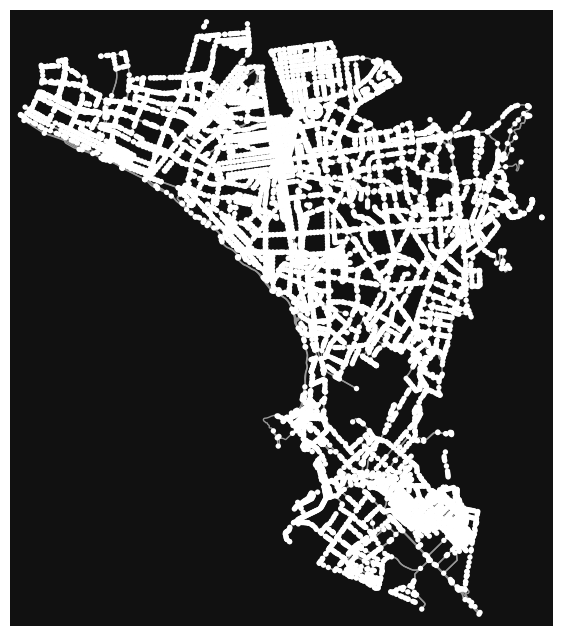

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [12]:
# Guardar el grafo
ox.save_graphml(G_lima, filepath='lima_moderna2.graphml')

# Más tarde, cargar el grafo
G_lima = ox.load_graphml('lima_moderna2.graphml')

# Ahora puedes trabajar con G_loaded
ox.plot_graph(G_lima)

In [13]:
G = G_lima

In [14]:
print(len(G.nodes))

10308


In [15]:
# def get_coordinates(location):
#     geolocator = Nominatim(user_agent="geoapi_Exercises")
#     location = geolocator.geocode(location)
#     return (location.latitude, location.longitude)


# upcSanIsidro_coords = get_coordinates("UPC San Miguel, Lima, Peru")
# upcSanMiguel_coords = get_coordinates("UPC San Isidro, Lima, Peru")

# print("Coordenadas de UPC San Isidro:", upcSanIsidro_coords)
# print("Coordenadas de UPC San Miguel:", upcSanMiguel_coords)

In [16]:
# upcSanIsidro_node = ox.distance.nearest_nodes(G, upcSanIsidro_coords[1], upcSanIsidro_coords[0])
# upcSanMiguel_node = ox.distance.nearest_nodes(G, upcSanMiguel_coords[1], upcSanMiguel_coords[0])
# print("Nodo de UPC San Isidro:", upcSanIsidro_node)
# print("Nodo de UPC San Miguel:", upcSanMiguel_node)

In [17]:
# def haversine(lon1,lat1, lon2,lat2):
#     R = 6371  # ratio of earth in km
#     phi1 = math.radians(lat1)
#     phi2 = math.radians(lat2)
#     delta_phi = math.radians(lat2 - lat1)
#     delta_lambda = math.radians(lon2 - lon1)

#     a = math.sin(delta_phi / 2) ** 2 + math.cos(phi1) * math.cos(phi2) * math.sin(delta_lambda / 2) ** 2
#     c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

#     distance = R * c
#     return distance

# def heuristic(node1, node2, G):
#     x1, y1 = G.nodes[node1]['x'], G.nodes[node1]['y']
#     x2, y2 = G.nodes[node2]['x'], G.nodes[node2]['y']
#     return haversine(x1,y1, x2,y2)

# def astar(G, start, goal):
#     open_list = []
#     heapq.heappush(open_list, (0, start))
    
#     came_from = {}
#     g_costs = {start: 0}
#     f_costs = {start: heuristic(start, goal, G)}
#     seti = {}
#     unique = []
    
#     path = []
#     while open_list:
#         # Obtener el nodo con menor costo f (g + h)
#         current = heapq.heappop(open_list)[1]
        
#         if current == goal:
#             while current in came_from:
#                 path.append(current)
#                 current = came_from[current]
#             path.append(start)
        
#         for neighbor in G.neighbors(current):
#             if (current, neighbor) not in seti: 
#                 seti[(current, neighbor)] = 1
#                 unique.append((current, neighbor))
            
#             tentative_g_cost = g_costs[current] + heuristic(current, neighbor, G)
            
#             if neighbor not in g_costs or tentative_g_cost < g_costs[neighbor]:
#                 came_from[neighbor] = current
#                 g_costs[neighbor] = tentative_g_cost
#                 f_costs[neighbor] = tentative_g_cost
#                 heapq.heappush(open_list, (f_costs[neighbor], neighbor))
        
#     return path[::-1], g_costs[goal], unique


# start_node = upcSanIsidro_node
# goal_node = upcSanMiguel_node


# path, cost, uniqueEdges = astar(G,start_node, goal_node)

# if path:
#     print(f"Camino encontrado: {path}")
# else:
#     print("No se encontró un camino.")

# print(f"Numero de conexiones totales acumuladas: {len(uniqueEdges)}")
# print(f"Conexiones Unicas: {uniqueEdges}")
# route_length = sum(heuristic(path[i], path[i+1], G) for i in range(len(path) - 1))
# print(f"Distancia desde la UPC San Isidro al de San Miguel utilizando A*: {route_length:.2f} km")                                                                                                                                                                                                                                                                                                           

In [18]:
# def writeHeaders():
#     headers = ['Dia', 'Hora', 'Latitud Central', 'Longitud Central', 'Tipo de Via', 'Congestion','Congestion_Numeric','Distance','Duration']
#     with open('data.csv', mode='w', newline='') as file:
#         writer = csv.DictWriter(file, fieldnames=headers)
#         writer.writeheader()

# writeHeaders()

In [19]:

def defineCoordsCentrals(uniqueEdges):
    coordinates = []

    for edge in G.edges:
        node1, node2 = edge[0], edge[1]
        uniqueEdges.append((node1, node2))
        x1, y1 = transformNodeToCoordenates(node1)
        #Longitud y Latitud
        x2, y2 = transformNodeToCoordenates(node2) 
        coordinates.append(((y1+y2)/2, (x1+x2)/2))  # Coord Central
    return coordinates

def transformNodeToCoordenates(node):
    return (G.nodes[node]['x'], G.nodes[node]['y'])


def defineRoadType(node1):
    return roadNameof[node1]

def defineDirections(coords1, coords2):
    access_token = get_env_variable('API_KEY_MPBOX')
    
    coordinates = f"{coords1[0]},{coords1[1]};{coords2[0]},{coords2[1]}"  # "long1,lat1;long2,lat2"
    
    directions_url = f"https://api.mapbox.com/directions/v5/mapbox/driving-traffic/{coordinates}"
    
    directions_params = {
        "access_token": access_token,
        "alternatives": "false",
        "geometries": "geojson",
        "overview": "full",
        "annotations": "congestion,congestion_numeric,distance,duration"
    }

    response = requests.get(directions_url, params=directions_params)
    if response.status_code == 200:
        directions = response.json()
        return directions
    else:
        return None
    
def defineCongestion(directions):
    if (directions == None): return -1
    congestion_levels = directions['routes'][0]['legs'][0]['annotation']['congestion']
    return Counter(congestion_levels).most_common(1)[0][0] #valor mas frecuente

def defineCongestionNumeric(directions):
    if (directions['routes'][0]['legs'][0]['annotation']['congestion_numeric'] != None):
        congestion_numeric = directions['routes'][0]['legs'][0]['annotation']['congestion_numeric']
        if (Counter(congestion_numeric).most_common(1)[0][0] == None):
            return -1
        return Counter(congestion_numeric).most_common(1)[0][0] #valor mas frecuente
    return -1

def defineDistance(directions):
    if (directions == None): return -1
    congestionNumeric_levels = directions['routes'][0]['legs'][0]['annotation']['distance']
    return Counter(congestionNumeric_levels).most_common(1)[0][0] #valor mas frecuente

def defineDuration(directions):
    if (directions == None): return -1
    congestionNumeric_levels = directions['routes'][0]['legs'][0]['annotation']['duration']
    return Counter(congestionNumeric_levels).most_common(1)[0][0] #valor mas frecuente

def saveSingleExample(dia, hora, latcentral, loncentral, tipo_via, congestion, congestion_numeric, distance, duration):
    with open('data.csv', mode='a+', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([dia, hora, latcentral, loncentral, tipo_via, congestion, congestion_numeric, distance, duration])


def defineDayHour():
    now = datetime.now()
    dia = now.strftime("%A")  # Día de la semana
    hora = now.strftime("%H:%M")  # Hora en formato HH:MM
    return dia, hora

uniqueEdges = []
coordinatesCentrals = defineCoordsCentrals(uniqueEdges)


#UniqueEdges son mis conexiones unicas (node1, node2)
#Las coordenadas centrales se calculan a partir de estas dos de aqui, ya convertidas a coordenadas
# i = 0
# getCongestion = {}
# getCongestion_Edge = {}
# for y,x in coordinatesCentrals:
#     day, hour = defineDayHour()
#     node1, node2 = uniqueEdges[i]
#     roadType = defineRoadType(node1)
#     directions = defineDirections(transformNodeToCoordenates(node1), transformNodeToCoordenates(node2))
#     congestion = defineCongestion(directions)
#     congestion_numeric = defineCongestionNumeric(directions)
#     distance = defineDistance(directions)
#     duration = defineDuration(directions)
#     getCongestion[node1] = congestion_numeric
#     getCongestion[node2] = congestion_numeric
#     getCongestion_Edge[(node1,node2)] = congestion_numeric
#     i+=1
#     saveSingleExample(day, hour, y, x, roadType, congestion, congestion_numeric,distance, duration)

# print(coordinatesCentrals)
# print("Datos guardados en CSV.")


In [20]:
# Función para recopilar datos
getCongestion = {}
getCongestion_Edge = {}

def getTraffic_Lima():
        print("Tamanio: ", len(coordinatesCentrals))
        i = 0
        for y,x in coordinatesCentrals:
            day, hour = defineDayHour()
            node1, node2 = uniqueEdges[i]
            roadType = defineRoadType(node1)
            directions = defineDirections(transformNodeToCoordenates(node1), transformNodeToCoordenates(node2))
            congestion = defineCongestion(directions)
            congestion_numeric = defineCongestionNumeric(directions)
            distance = defineDistance(directions)
            duration = defineDuration(directions)
            getCongestion[node1] = congestion_numeric
            getCongestion[node2] = congestion_numeric
            getCongestion_Edge[(node1,node2)] = congestion_numeric
            i+=1
            saveSingleExample(day, hour, y, x, roadType, congestion, congestion_numeric,distance, duration)            

# getTraffic_Lima()

In [ ]:
def run_at_specific_times():
    execution_hours = [6, 7, 8, 9, 10, 12, 14, 16, 18, 19, 20, 21,22, 0]
    try_number = 1

    while True:
        now = datetime.now()
        current_hour = now.hour

        if current_hour in execution_hours:
            print(f"Iniciando recopilación de datos: try {try_number} a las {current_hour}:00")
            getTraffic_Lima()
            try_number += 1
            print("Try Number: ", try_number)
            time.sleep(3600 - now.minute * 60 - now.second)
        else:
            time.sleep(60)

run_at_specific_times()

Iniciando recopilación de datos: try 1 a las 21:00
Tamanio:  15532
Try Number:  2


In [55]:
# # Aproximar los nodos más cercanos a las coordenadas al grafo de Lima
# nodes = [ox.distance.nearest_nodes(G, coord[0], coord[1]) for coord in coordinatesCentrals]

# print(len(nodes))

## USANDO MAPBOX

In [ ]:
# # Imprimir posiciones de los nodos para verificar que todos tienen 'x' y 'y'
# for node in nodes:
#     if 'x' in G.nodes[node] and 'y' in G.nodes[node]:
#         print(f"Nodo {node}: ({G.nodes[node]['x']}, {G.nodes[node]['y']})")
#     else:
#         print(f"Nodo {node} no tiene coordenadas.")


In [57]:
# import pickle
# data1 = getCongestion
# # Guardar en un archivo
# with open('getCongestion.pkl', 'wb') as f:
#     pickle.dump(data1, f)

In [58]:
# data2 = getCongestion_Edge
# # Guardar en un archivo
# with open('getCongestion_Edge.pkl', 'wb') as f:
#     pickle.dump(data2, f)

In [59]:
# # Cargar desde el archivo
# with open('getCongestion.pkl', 'rb') as f:
#     getCongestion = pickle.load(f)

# # Cargar desde el archivo
# with open('getCongestion_Edge.pkl', 'rb') as f:
#     getCongestion_Edge = pickle.load(f)


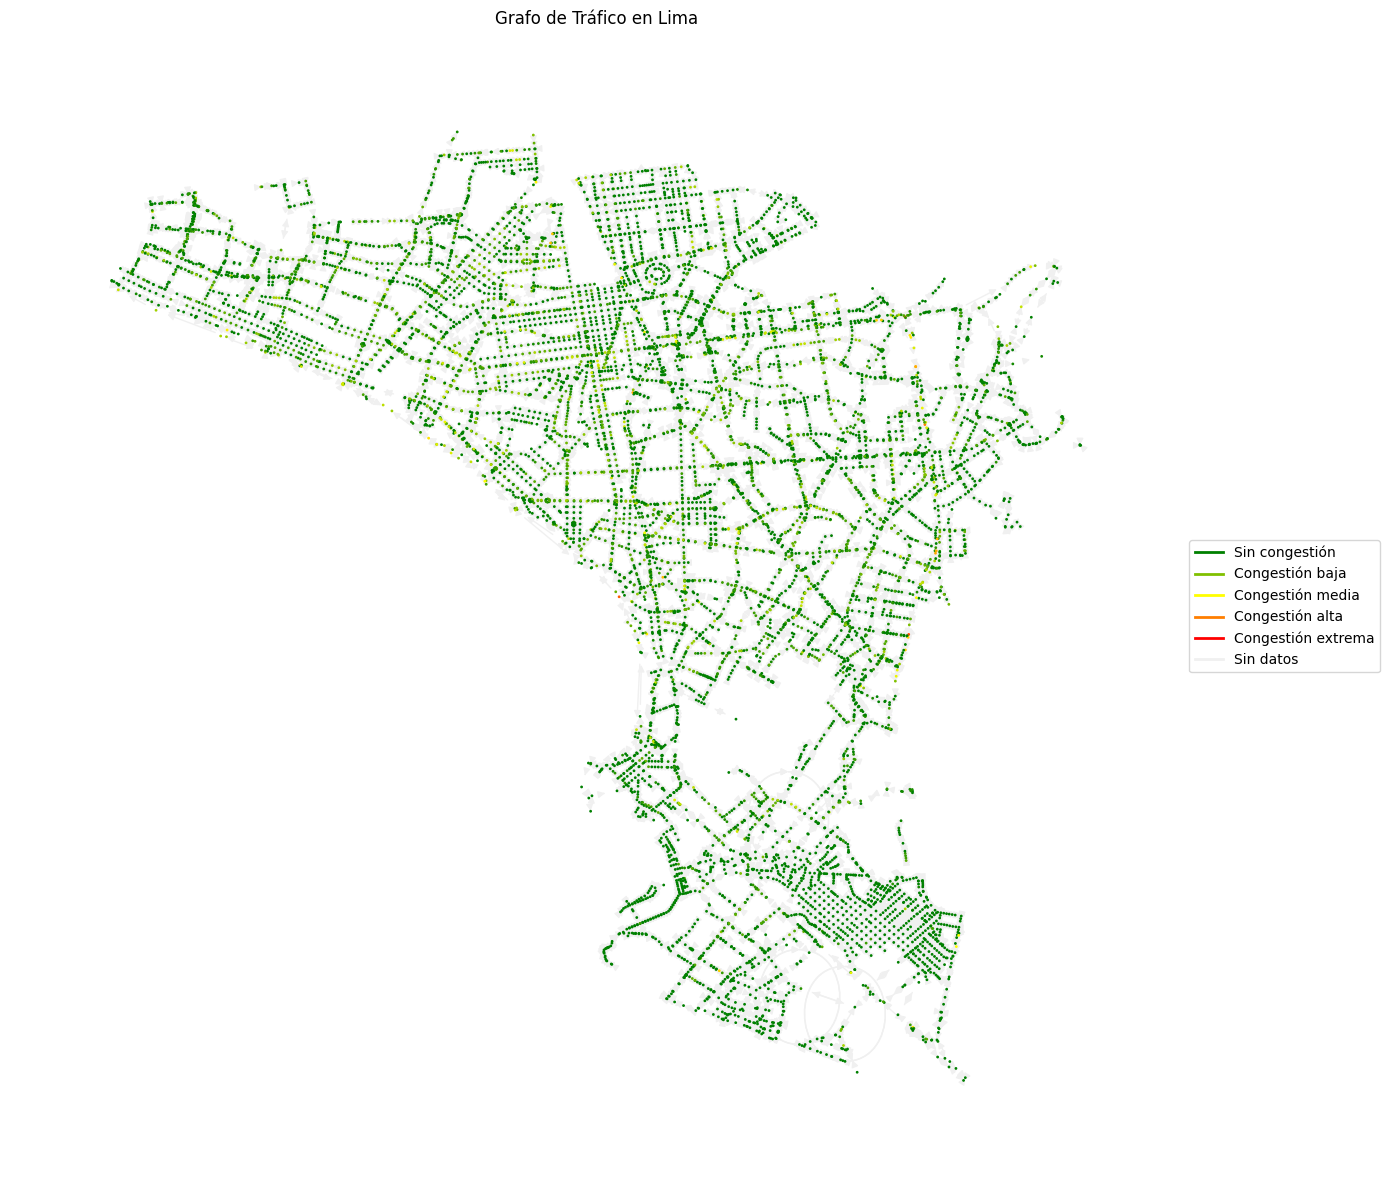

In [60]:
def congestion_to_color(congestion):
    if congestion is None:
        return '#A9A9A9'
    
    cmap = mcolors.LinearSegmentedColormap.from_list("", ["green", "yellow", "red"])
    return mcolors.to_hex(cmap(congestion / 100))


edge_colors = []
edge_widths = []

for edge in G.edges:
    if edge in getCongestion_Edge:
        congestion_level = getCongestion_Edge[edge]
        edge_colors.append(congestion_to_color(congestion_level))
        edge_widths.append(1 + (congestion_level / 25))  
    else:
        edge_colors.append('#f0f0f0') 
        edge_widths.append(1)

pos = {node: (G.nodes[node]['x'], G.nodes[node]['y']) for node in G.nodes}

node_colors = []
for node in G.nodes():
    if node in getCongestion:
        congestion_level = getCongestion[node]
        node_colors.append(congestion_to_color(congestion_level))
    else:
        node_colors.append('#A9A9A9') 

plt.figure(figsize=(14, 12))

nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=1)
nx.draw_networkx_edges(G, pos, edge_color=edge_colors, alpha=1, width=edge_widths)

plt.title('Grafo de Tráfico en Lima')
plt.axis('off')

# Crear la leyenda
legend_elements = [
    Line2D([0], [0], color=congestion_to_color(0), lw=2, label='Sin congestión'),
    Line2D([0], [0], color=congestion_to_color(25), lw=2, label='Congestión baja'),
    Line2D([0], [0], color=congestion_to_color(50), lw=2, label='Congestión media'),
    Line2D([0], [0], color=congestion_to_color(75), lw=2, label='Congestión alta'),
    Line2D([0], [0], color=congestion_to_color(100), lw=2, label='Congestión extrema'),
    Line2D([0], [0], color='#f0f0f0', lw=2, label='Sin datos')
]

# Añadir la leyenda
plt.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()